In [2]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import scipy
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from scipy.optimize import fsolve
import math
import random

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [3]:
if not os.path.exists('constituents-financials.csv'):
    urllib.request.urlretrieve(
        "https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv", "constituents-financials.csv")
data = pd.read_csv('constituents-financials.csv')
data


,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89000,24.31000,2.33286,7.92000,259.77000,175.49000,138721055226,9048000000.00000,4.39027,11.34000,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24000,27.76000,1.14796,1.70000,68.39000,48.92500,10783419933,601000000.00000,3.57548,6.35000,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27000,22.51000,1.90898,0.26000,64.60000,42.28000,102121042306,5744000000.00000,3.74048,3.19000,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48000,19.41000,2.49956,3.29000,125.86000,60.05000,181386347059,10310000000.00000,6.29157,26.14000,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51000,25.47000,1.71447,5.44000,162.60000,114.82000,98765855553,5643228000.00000,2.60412,10.62000,http://www.sec.gov/cgi-bin/browse-edgar?action...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,Industrials,70.24000,30.94000,1.17008,1.83000,76.81000,46.86000,12915021000,722000000.00000,2.72621,5.31000,http://www.sec.gov/cgi-bin/browse-edgar?action...
501,YUM,Yum! Brands Inc,Consumer Discretionary,76.30000,27.25000,1.79708,4.07000,86.93000,62.85000,27003303098,2289000000.00000,6.31364,212.08000,http://www.sec.gov/cgi-bin/browse-edgar?action...
502,ZBH,Zimmer Biomet Holdings,Health Care,115.53000,14.32000,0.79483,9.01000,133.49000,108.17000,24454698119,2007400000.00000,3.16490,2.39000,http://www.sec.gov/cgi-bin/browse-edgar?action...
503,ZION,Zions Bancorp,Financials,50.71000,17.73000,1.48093,2.60000,55.61000,38.43000,10670678640,0.00000,3.79458,1.42000,http://www.sec.gov/cgi-bin/browse-edgar?action...


# Approximating Price distribution using Inverse Transform

params from lab #1: mu 4.4376924074345245 sigma 0.7008615631875369
Mode 51.75315915112879
Target diff 0.40535607267990625
guessed params: m=[4.43769241], s=[0.70086156]


<AxesSubplot:xlabel='Price', ylabel='Density'>

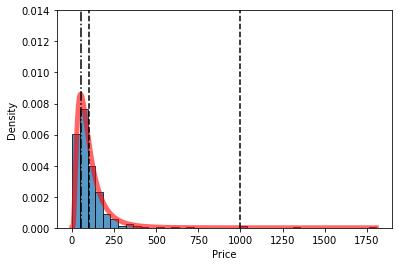

In [4]:
# From lab #1 values for Price
mu = 4.4376924074345245
sigma = 0.7008615631875369
print('params from lab #1: mu', mu, 'sigma', sigma)
target_modal_value = math.exp(mu-sigma**2)
print('Mode', target_modal_value)
boundary_values = 1000, 100
target_diff = st.lognorm.cdf(boundary_values[0], s=sigma, scale=math.exp(mu)) - st.lognorm.cdf(boundary_values[1], s=sigma, scale=math.exp(mu))
print('Target diff', target_diff)
# Define function to find roots of


def equation(s):

    # From Wikipedia: Mode = exp(m - s*s)
    m = math.log(target_modal_value) + s**2

    # Get probability mass from CDF at boundary_values[1] and boundary_values[0], should be equal to target_diff.
    # Rearange equation so that =0, to find root (value of s)
    return (st.lognorm.cdf(boundary_values[0], s=s, scale=math.exp(m)) - st.lognorm.cdf(boundary_values[1], s=s, scale=math.exp(m)) - target_diff)


# Solve non-linear equation to find s
s_initial_guess = 1
s = fsolve(equation, s_initial_guess)

# From s, find m
m = math.log(target_modal_value) + s**2
print('guessed params: m='+str(m)+', s='+str(s))  # (m,s))

# Plot
x = np.arange(0, max(data.Price), 1)
y = st.lognorm.pdf(x, s=s, scale=math.exp(m))
fig, ax = plt.subplots()
ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.plot((boundary_values[1], boundary_values[1]), (0, 1), 'k--')
plt.plot((target_modal_value, target_modal_value), (0, 1), 'k-.')
plt.plot((boundary_values[0], boundary_values[0]), (0, 1), 'k--')
plt.ylim(0, 0.014)
sns.histplot(data.Price, kde=False, bins=40, stat='density', label=f'Average price in dollars')

# Approximating Price using Accept-Reject sampling

C:\Users\morko\AppData\Local\Temp/ipykernel_15956/997392838.py:3: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))
C:\Users\morko\AppData\Local\Temp/ipykernel_15956/997392838.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return exp / frac


Text(0.5, 1.0, 'M=3')

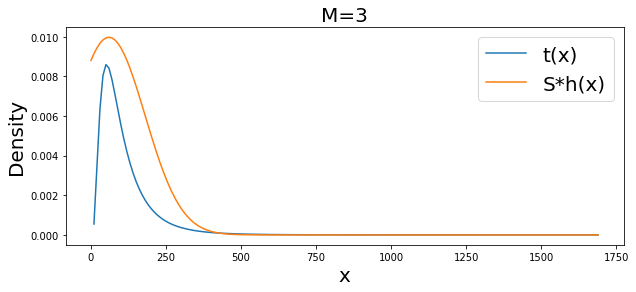

In [5]:
# lognormal PDF
def lognorm_pdf(x, mu_, sigma_):
    exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))
    frac = (x * sigma_ * (2 * np.pi) ** 0.5)
    return exp / frac

# normal PDF


def g(x, mu_, sigma_):
    return 1/np.sqrt(2*np.pi)/sigma_ * np.exp(-0.5*((x-mu_)/sigma_)**2)

upper_params = 60, 120

M = 3
x_vals = np.arange(0, 1700, 10)
f_vals = [lognorm_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)


C:\Users\morko\AppData\Local\Temp/ipykernel_15956/997392838.py:3: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))


Num Samples Collected: 33183
Efficiency: 0.332


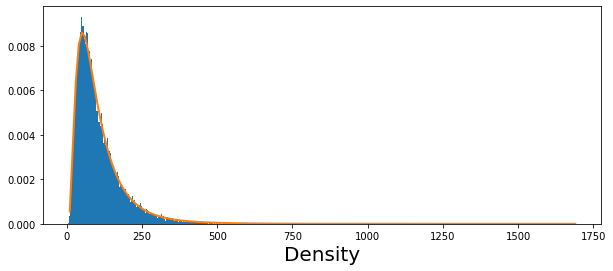

In [6]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = lognorm_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)


# Approximating Dividend Yield distribution using Inverse Transform

params from lab #1: mu 0.7423118497542172 sigma 0.6016495934841037
Mode 1.4627666618828938
Target diff 0.35879631961105746
guessed params: m=[0.74231185], s=[0.60164959]


<AxesSubplot:xlabel='Dividend Yield', ylabel='Density'>

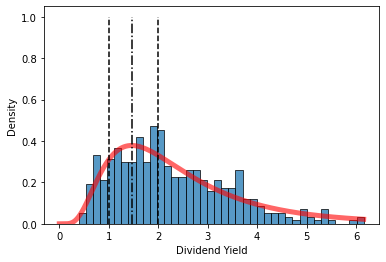

In [7]:
# From lab #1 values for Div Yield
mu = 0.7423118497542172
sigma = 0.6016495934841037
# apply the same filtering as in lab 1
div_yield = data['Dividend Yield']
div_yield = div_yield[div_yield.between(div_yield.quantile(0.2), div_yield.quantile(.99))].reset_index(drop=True)
print('params from lab #1: mu', mu, 'sigma', sigma)
target_modal_value = math.exp(mu-sigma**2)
print('Mode', target_modal_value)
boundary_values = 2, 1
target_diff = st.lognorm.cdf(boundary_values[0], s=sigma, scale=math.exp(mu)) - st.lognorm.cdf(boundary_values[1], s=sigma, scale=math.exp(mu))
print('Target diff', target_diff)
# Define function to find roots of


def equation(s):

    # From Wikipedia: Mode = exp(m - s*s)
    m = math.log(target_modal_value) + s**2

    # Get probability mass from CDF at boundary_values[1] and boundary_values[0], should be equal to target_diff.
    # Rearange equation so that =0, to find root (value of s)
    return (st.lognorm.cdf(boundary_values[0], s=s, scale=math.exp(m)) - st.lognorm.cdf(boundary_values[1], s=s, scale=math.exp(m)) - target_diff)


# Solve non-linear equation to find s
s_initial_guess = 1
s = fsolve(equation, s_initial_guess)

# From s, find m
m = math.log(target_modal_value) + s**2
print('guessed params: m='+str(m)+', s='+str(s))  # (m,s))

# Plot
x = np.arange(0, max(div_yield), 1e-4)
y = st.lognorm.pdf(x, s=s, scale=math.exp(m))
fig, ax = plt.subplots()
ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.plot((boundary_values[1], boundary_values[1]), (0, 1), 'k--')
plt.plot((target_modal_value, target_modal_value), (0, 1), 'k-.')
plt.plot((boundary_values[0], boundary_values[0]), (0, 1), 'k--')

sns.histplot(div_yield, kde=False, bins=40, stat='density', label=f'Dividend Yield')

# Approximating Dividend Yield using Accept-Reject sampling

C:\Users\morko\AppData\Local\Temp/ipykernel_15956/4216565273.py:5: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))
C:\Users\morko\AppData\Local\Temp/ipykernel_15956/4216565273.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return exp / frac


Text(0.5, 1.0, 'M=2')

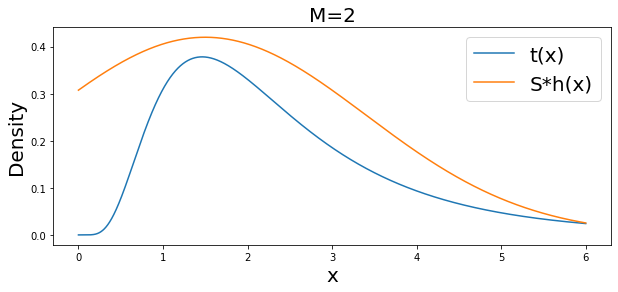

In [8]:
mu = 0.7423118497542172
sigma = 0.6016495934841037
# lognormal PDF
def lognorm_pdf(x, mu, sigma):
    exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))
    frac = (x * sigma * (2 * np.pi) ** 0.5)
    return exp / frac

# normal PDF


def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

upper_params = 1.5, 1.9
M = 2
x_vals = np.arange(0, 6, 1e-4)
f_vals = [lognorm_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)


C:\Users\morko\AppData\Local\Temp/ipykernel_15956/4216565273.py:5: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))


Num Samples Collected: 48893
Efficiency: 0.489


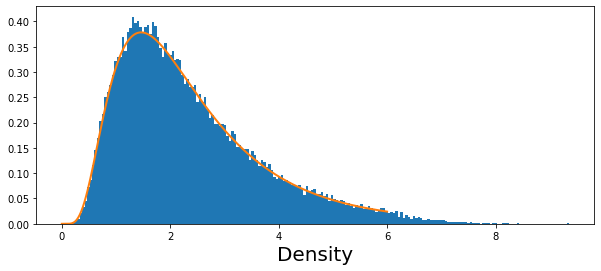

In [9]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = lognorm_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)


# Estimating correlations between targets and predictors

In [10]:
data.corr()

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
Price,1.00000,0.19476,-0.24463,0.59106,0.99508,0.98279,0.40647,0.18032,0.18162,0.02364
Price/Earnings,0.19476,1.00000,-0.18133,0.00457,0.18536,0.14470,0.13138,0.00295,0.18856,0.00037
Dividend Yield,-0.24463,-0.18133,1.00000,-0.07724,-0.24443,-0.20795,-0.02179,0.12613,-0.07772,0.08937
Earnings/Share,0.59106,0.00457,-0.07724,1.00000,0.58859,0.60489,0.19406,0.18058,-0.03618,0.03225
52 Week Low,0.99508,0.18536,-0.24443,0.58859,1.00000,0.98485,0.39850,0.17628,0.18882,0.02332
52 Week High,0.98279,0.14470,-0.20795,0.60489,0.98485,1.00000,0.37559,0.17967,0.17372,0.01779
Market Cap,0.40647,0.13138,-0.02179,0.19406,0.39850,0.37559,1.00000,0.77134,0.09525,0.03441
EBITDA,0.18032,0.00295,0.12613,0.18058,0.17628,0.17967,0.77134,1.00000,-0.03717,0.03555
Price/Sales,0.18162,0.18856,-0.07772,-0.03618,0.18882,0.17372,0.09525,-0.03717,1.00000,0.01234
Price/Book,0.02364,0.00037,0.08937,0.03225,0.02332,0.01779,0.03441,0.03555,0.01234,1.00000


# Bayes network

In [11]:

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN


In [16]:
data = data[['Price',	'Price/Earnings', 'Dividend Yield',	'Earnings/Share',
             '52 Week Low',	'52 Week High',	'Market Cap',	'EBITDA',
             'Price/Sales',	'Price/Book']]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
nodes_type = get_nodes_type(data)
print(nodes_type)
nodes_sign = get_nodes_sign(data)
print(nodes_sign)
coded_data, coder = code_categories(
    data, 'label', ['Price', 'Price/Earnings', 'Dividend Yield', 'Earnings/Share'])
discrete_data, coder = discretization(coded_data, 'equal_frequency',
                                      ['Price',	'Price/Earnings', 'Dividend Yield',	'Earnings/Share',
                                       '52 Week Low',	'52 Week High',	'Market Cap',	'EBITDA',
                                       'Price/Sales',	'Price/Book'])
bn = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
print(bn)


G:\Programming\itmo_algorithms\itmo\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


{'Price': 'cont', 'Price/Earnings': 'cont', 'Dividend Yield': 'cont', 'Earnings/Share': 'cont', '52 Week Low': 'cont', '52 Week High': 'cont', 'Market Cap': 'disc', 'EBITDA': 'cont', 'Price/Sales': 'cont', 'Price/Book': 'cont'}
{'Price': 'pos', 'Price/Earnings': 'neg', 'Dividend Yield': 'pos', 'Earnings/Share': 'neg', '52 Week Low': 'pos', '52 Week High': 'pos', 'EBITDA': 'neg', 'Price/Sales': 'pos', 'Price/Book': 'pos'}
{'V': ['Price', 'Price/Earnings', 'Dividend Yield', 'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book'], 'E': [['Price/Earnings', 'Price/Book'], ['Price/Earnings', 'Dividend Yield'], ['52 Week Low', 'Price'], ['52 Week Low', '52 Week High'], ['52 Week High', 'Earnings/Share'], ['Market Cap', 'EBITDA'], ['Price/Sales', 'Price/Earnings'], ['Price/Book', '52 Week Low'], ['Price/Book', 'Dividend Yield'], ['Price/Book', 'EBITDA']]}


In [14]:
draw_BN(bn, nodes_type, 'geo_bn')


saving on ../visualization_result`/geo_bn.html
g:\Programming\multidimensional_data_processing\BAMT\geo_bn.html


In [15]:
params = parameter_learning(data, nodes_type, bn, 'simple')
save_structure(bn, 'geo_net_structure')
skel = read_structure('geo_net_structure')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(geo_bn, nodes_sign, 'simple', 800)
sns.distplot(data['Price'])
sns.distplot(synth_df['Price'])


KeyError: 'Sector'